In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm
import unidecode

import matplotlib as mpl
font = {        'size'   : 15}
mpl.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import imageio

In [57]:
def remove_accent(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

def names_to_ids(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')).applymap(lambda x: city_to_code[x])

def users_per_city(W):
    n = np.zeros([W.shape[0],W.shape[1]],dtype='int')
    for t in range(W.shape[0]):
        n[t,:] = np.sum(W[0,:,:],axis=1) + np.sum(W[0:t+1,:,:],axis=(0,1))
    n[n==0]+=1 # artificially ensuring no cities have 0 users!
    return n  

def users_per_city_a(W):
    n = np.zeros([W.shape[0],W.shape[1]],dtype='int')
    for t in range(W.shape[0]):
        n[t,:] = np.sum(W[t,:,:],axis=(0,1))
    n[n==0]+=1 # artificially ensuring no cities have 0 users!
    return n  

# Getting the top 19 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]
iwiw_code_dict= {379: 'Budapest', 380: 'Debrecen', 381: 'Miskolc', 382: 'Szeged', 383: 'Pecs', 384: 'Gyor', 385: 'Nyiregyhaza', 386: 'Kecskemet',
 387: 'Szekesfehervar', 388: 'Szombathely', 389: 'Szolnok', 390: 'Tatabanya', 391: 'Kaposvar', 392: 'Bekescsaba', 393: 'Zalaegerszeg',
 394: 'Veszprem', 396: 'Eger', 1842: 'Szekszard', 2103: 'Salgotarjan'}
city_to_code = {v:k for k,v in iwiw_code_dict.items()}

# useful masks
mask_SL_t = ~np.eye(19,dtype=bool) # mask for self loops in a snapshot
mask_SL = np.array([mask_SL_t]*11) # mask for self loops across all snapshots

# Reading data
## Infrastructural

In [3]:
shortest_paths = pd.read_csv('../simplified_roads/hungary/data/shortest_paths.csv')
shortest_paths[['source','target']]=names_to_ids(shortest_paths[['source','target']])
shortest_paths['length'] = shortest_paths['length'].apply(lambda x:x/1000)

node_list=shortest_paths['source'].unique() # all the unique nodes
Years=shortest_paths['year'].unique() # all the unique years

# Turning dataframe into usable nx networks
graphs = {y:nx.from_pandas_edgelist(shortest_paths[shortest_paths['year']==y],
                                    source='source',target='target',edge_attr=['travel_time','length'],) 
          for y in Years}

# Turning nx networks into adjacency matrices (tensors) of travel time and distances
travel_time_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='travel_time') for y in Years])
length_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='length') for y in Years])

## Social

In [4]:
connections = pd.read_csv('../analysis/all_spatiosocial_data.csv')
graphs_S = {y:nx.from_pandas_edgelist(connections[connections['Year']==y],
                                    source='CityID_From',target='CityID_To',edge_attr='Connections') 
          for y in Years}

S = np.array([nx.to_numpy_array(graphs_S[y],dtype=np.float32,weight='Connections') for y in Years])

# Reconstructing W tensor which has not been saved as a data file
invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
reduced_df = invitations_iwiw[mask1&mask2]
graphs_W = {year:nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                                        source='InvitorCityId',target='CityId',edge_attr='w',
                                                        create_using=nx.DiGraph)
            for year in Years}

# asymmetric, weighted tensor of size T x N x N
W = np.array([nx.to_numpy_array(graphs_W[y],dtype=np.float32,weight='w') for y in Years])
# W is useful for city populations, so should maintain the self loops

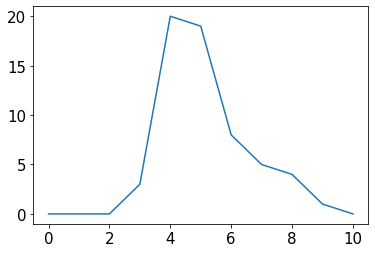

In [5]:
plt.plot([np.median(W[t,:,:][mask_SL_t]) for t in range(S.shape[0])])

# Least-squares optimization
## Defining model functions and residuals

In [53]:
np.ones(10).shape

(10,)

In [68]:
## GRAVITY
n=users_per_city(W)
def gravity_model(dist,alpha=1,beta=1,gamma=2,d_0=1,n=n,sigmoid=None):
    if type(sigmoid) == type(None):
        sigmoid = np.ones(dist.shape[0])
    # this will output the entire tensor
    return np.array([sigmoid[t]*np.outer(n[t,:]**alpha,n[t,:]**beta)*d_0**gamma/(dist[t,:,:]**gamma) for t in range(n.shape[0])])

def residual_social_gravity(x,n,dist,social,sigmoid):
    # residual to use in sp.optimize.least_squares
    if len(x) == 3:
        d_0,gamma,alpha=x
    else:
        d_0,gamma=x
        alpha=(1,1)
    G = gravity_model(dist,d_0=d_0,gamma=gamma,alpha=alpha,beta=alpha,n=n,sigmoid=sigmoid)
    return (social-G)[mask_SL]

def gravity_model_t(dist,t,alpha=1,beta=1,gamma=2,d_0=1,n=n,sigmoid=None):
    if type(sigmoid) == type(None):
        sigmoid = np.ones(dist.shape[0])
    return sigmoid[t]*np.outer(n[t,:]**alpha,n[t,:]**beta)*d_0**gamma/(dist[t,:,:]**gamma)

def residual_social_gravity_t(x,t,dist,social,n,sigmoid):
    if len(x)==3:
        d_0,gamma,alpha=x
    else:
        d_0,gamma=x
        alpha,beta=(1,1)
    G = gravity_model_t(dist,t,d_0=d_0,gamma=gamma,
                        alpha=alpha,beta=alpha,n=n,sigmoid=sigmoid)
    return social[t,:,:][mask_SL_t]-G[mask_SL_t]

In [59]:
## RADIATION
def radiation_model(dist,c=1,n=n):
    out = np.zeros_like(S)
    m = np.zeros_like(S)
    for t in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[2]):
                    if dist[t,i,k] <= dist[t,i,j]:
                        m[t,i,j] += n[t,k]
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                out[t,i,j] = c*S.sum(axis=2)[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
    return out

def residual_social_radiation(x,n,dist,social):
    R = radiation_model(dist,c=x[0])
    return social[mask_SL] - R[mask_SL]

def radiation_model_t(dist,t,c=1,n=n):
    out = np.zeros_like(S[0,:,:])
    m = np.zeros_like(S)
    for t in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[2]):
                    if dist[t,i,k] <= dist[t,i,j]:
                        m[t,i,j] += n[t,k]
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            out[i,j] = c*S.sum(axis=2)[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
#                 out[t,i,j] = n[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
    return out

def residual_social_radiation_t(x,t,dist,social,n):
    R_t = radiation_model_t(dist,t,c=x[0],n=n)
    return social[t,:,:][mask_SL_t] - R_t[mask_SL_t]

In [76]:
def fit_model(dist,pop,model,each_year=False,bounds=None,x_0=None,social=S,sigmoid=None):
    if model.lower() == 'gravity':
        if not each_year:
            if bounds == None:
                bounds=([0,1,0],[np.inf,2,2])
            if x_0 == None:
                x_0 = [1e-10,2,1]
            parameters = sp.optimize.least_squares(residual_social_gravity,
                                         x_0,bounds=bounds,
                                         args=(pop,dist,social,sigmoid)).x
            return gravity_model(dist,d_0=parameters[0],gamma=parameters[1],
                                 alpha=parameters[2],beta=parameters[2],
                                 n=pop,sigmoid=sigmoid),parameters
        else:
            if bounds == None:
                bounds=([0,1,0],[np.inf,2,2])
            if x_0 == None:
                x_0 = [1e-10,2,1]
            parameters = [sp.optimize.least_squares(residual_social_gravity_t,
                                      x_0,bounds=bounds,
                                      args=(t,dist,social,pop,sigmoid)).x
                          for t in range(S.shape[0])]
            return np.array([gravity_model_t(dist,t,
                                             d_0=parameters[t][0],
                                             gamma=parameters[t][1],
                                             alpha=parameters[t][2],
                                             beta=parameters[t][2],
                                             n=pop,sigmoid=sigmoid) 
                             for t in range(S.shape[0])]),parameters
    elif model.lower() == 'radiation':
        if not each_year:
            if bounds == None:
                bounds=([0],[np.inf])
            if x_0 == None:
                x_0 = [1]
            parameters = sp.optimize.least_squares(residual_social_gravity,
                                         x_0,bounds=bounds,
                                         args=(pop,dist,social)).x
            return radiation_model(dist,c=parameters[0],n=pop),parameters
        else:
            if bounds == None:
                bounds=([0],[np.inf])
            if x_0 == None:
                x_0 = [1]
            parameters = [sp.optimize.least_squares(residual_social_radiation_t,
                                      x_0,bounds=bounds,
                                      args=(t,dist,social,pop)).x 
                          for t in range(S.shape[0])]
            return np.array([radiation_model_t(dist,t,c=parameters[t][0],n=pop) 
                             for t in range(S.shape[0])]),parameters
    else:
        print("Invalid model")
        return None

# Statistics

In [9]:
def chi2(obs,exp):
    # in cases of 0 expectations
    return np.sum((obs[exp!=0]-exp[exp!=0])**2/exp[exp!=0])

def upper_triangle(tensor):
    return np.array([tensor[t,i,j] for t in range(tensor.shape[0]) for i in range(S.shape[1]) for j in range(i+1,S.shape[2])])

In [10]:
G_0,p_0 = fit_model(travel_time_tensor,n,'gravity')
G_1,p_1 = fit_model(length_tensor,n,'gravity')
G_2,p_2 = fit_model(travel_time_tensor,n,'gravity',each_year=True)
G_3,p_2 = fit_model(length_tensor,n,'gravity',each_year=True)

G_models = [G_0,G_1,G_2,G_3]
print([chi2(upper_triangle(S),upper_triangle(G)) for G in G_models])

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


[4454818.932450068, 6516721.642925141, 8244618.823082169, 5380089.933178712]


In [11]:
n_ = users_per_city_a(W)
G_0_w,p_0_w = fit_model(travel_time_tensor,n_,'gravity',social=W)
G_1_w,p_1_w = fit_model(length_tensor,n_,'gravity',social=W)
G_2_w,p_2_w = fit_model(travel_time_tensor,n_,'gravity',
                        each_year=True,bounds=([0,1,0],[np.inf,4,2]),social=W)
G_3_w,p_3_w = fit_model(length_tensor,n_,'gravity',
                        each_year=True,bounds=([0,1,0],[np.inf,4,2]),social=W)

G_w_models = [G_0_w,G_1_w,G_2_w,G_3_w]
print([chi2(upper_triangle(S),upper_triangle(G)) for G in G_w_models])

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


[36822663643.07272, 37472733358.095985, 16429508970.562977, 13374644089.066116]


/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


# Figures

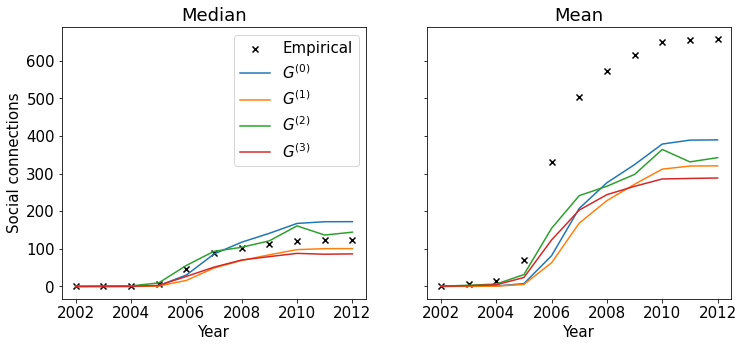

In [62]:
fig,axs=plt.subplots(figsize=(12,5),ncols=2,sharey=True)

axs[0].scatter(Years,[np.median(S[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
for v,g in enumerate(G_models):
    axs[0].plot(Years,[np.median(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[0].set_title("Median")
axs[0].legend()

axs[1].scatter(Years,[np.mean(S[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
for v,g in enumerate(G_models):
    axs[1].plot(Years,[np.mean(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[1].set_title("Mean")

axs[0].set_ylabel("Social connections")
for i in range(2):
    axs[i].set_xlabel("Year")
#     axs[i].set_yscale('log')
# fig.savefig("../analysis/Figures/Gravity models adjusted.png",bbox_inches='tight')

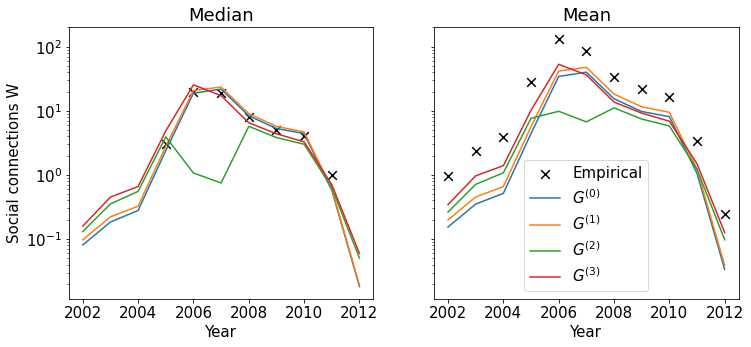

In [18]:
fig,axs=plt.subplots(figsize=(12,5),ncols=2,sharey=True)

axs[0].scatter(Years,[np.median(W[t,:,:][mask_SL_t]) for t in range(S.shape[0])],
               label='Empirical',marker='x',color='k',s=75)
for v,g in enumerate(G_w_models):
    axs[0].plot(Years,[np.median(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[0].set_title("Median")

axs[1].scatter(Years,[np.mean(W[t,:,:][mask_SL_t]) for t in range(S.shape[0])],
               label='Empirical',marker='x',color='k',s=75)
for v,g in enumerate(G_w_models):
    axs[1].plot(Years,[np.mean(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[1].set_title("Mean")

axs[0].set_ylabel("Social connections W")
axs[1].legend()
for i in range(2):
    axs[i].set_xlabel("Year")
    axs[i].set_yscale('log')
fig.savefig("../analysis/Figures/Gravity models adjusted vs W.png",bbox_inches='tight')

# Distributions of empirical vs null

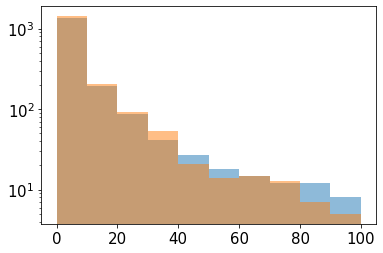

In [113]:
bins=np.linspace(0,100,11)
plt.hist(upper_triangle(W),alpha=0.5,bins=bins)
plt.hist(upper_triangle(G_0_w),alpha=0.5,bins=bins)
plt.yscale('log')

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


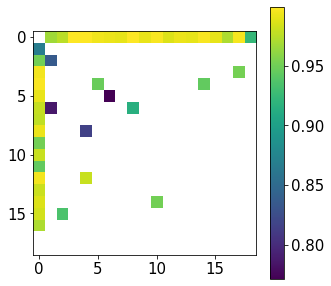

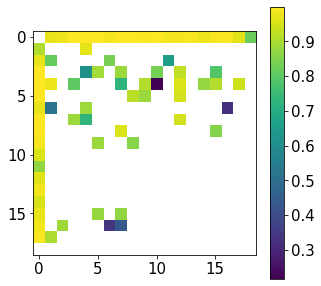

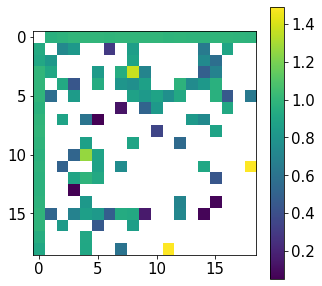

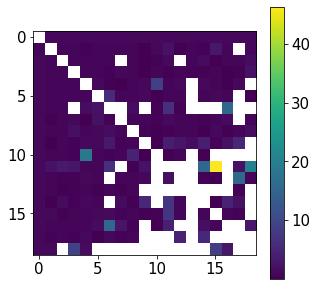

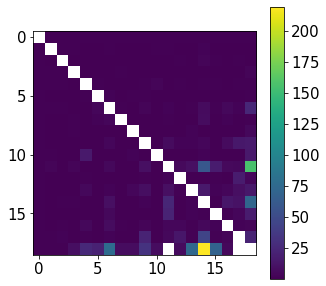

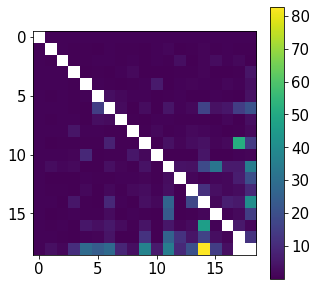

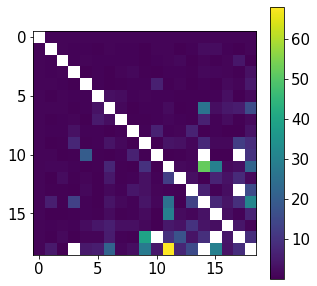

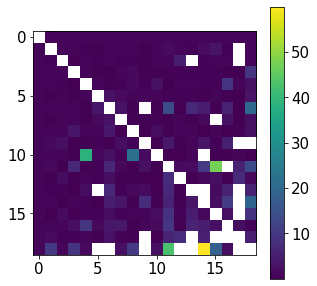

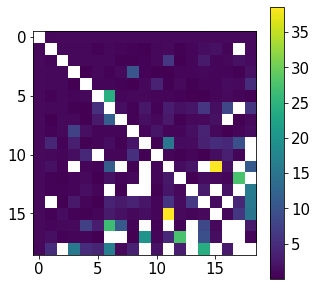

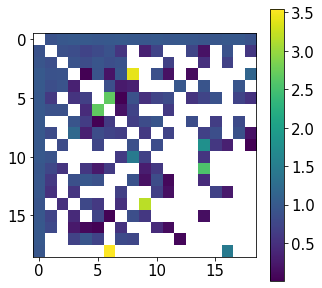

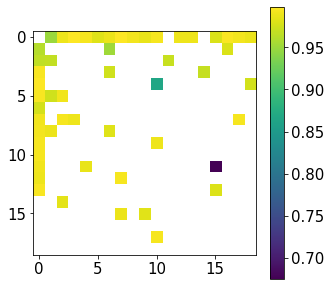

In [109]:
for t in range(S.shape[0]):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(np.abs(G_0_w[t,:,:]-W[t,:,:])/W[t,:,:])
    plt.colorbar()

# Susceptible-type population
The 'population' of a city is now the number of users available to send an invitation, that is the number of users in 2012 minus the number of users at time $t$. 

$n_i(t) = n_i(0) + \sum_{\tau=0}^t \sum_j w_{ji}(\tau)$

$n_i(2012) = n_i(0) + \sum_{\tau=0}^{2012} \sum_j w_{ji}(\tau)$

$n_{\text{sus}}:=n_i(2012) - n_i(t) = \sum_{\tau=t}^{2012} \sum_j w_{ji}(\tau)$

In [20]:
n_sus = n[-1,:]-n
social = W
G_0_sus,p_0_sus = fit_model(travel_time_tensor,n_sus,'gravity',social=social)
G_1_sus,p_1_sus = fit_model(length_tensor,n_sus,'gravity',social=social)
G_2_sus,p_2_sus = fit_model(travel_time_tensor,n_sus,'gravity',
                        each_year=True,bounds=([0,1,0],[np.inf,4,2]),social=social)
G_3_sus,p_3_sus = fit_model(length_tensor,n_sus,'gravity',
                        each_year=True,bounds=([0,1,0],[np.inf,4,2]),social=social)

G_sus_models = [G_0_sus,G_1_sus,G_2_sus,G_3_sus]
print([chi2(upper_triangle(S),upper_triangle(G)) for G in G_sus_models])

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


[3422342232.601762, 22281066311.583904, 201844096.9876072, 605360682.7527894]


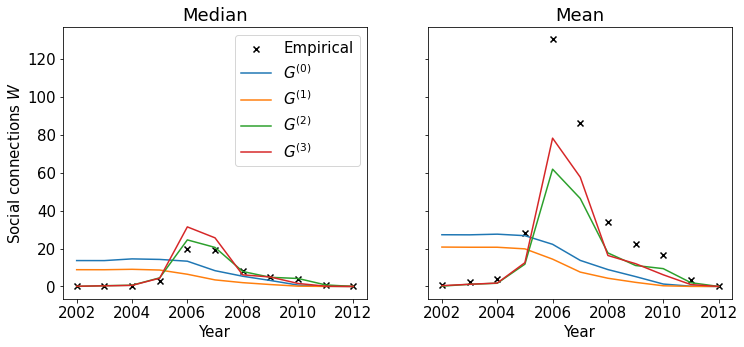

In [22]:
social = W
models = G_sus_models
fig,axs=plt.subplots(figsize=(12,5),ncols=2,sharey=True)

axs[0].scatter(Years,[np.median(social[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
for v,g in enumerate(models):
    axs[0].plot(Years,[np.median(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[0].set_title("Median")
axs[0].legend()

axs[1].scatter(Years,[np.mean(social[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
for v,g in enumerate(models):
    axs[1].plot(Years,[np.mean(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[1].set_title("Mean")

axs[0].set_ylabel("Social connections $W$")
for i in range(2):
    axs[i].set_xlabel("Year")
#     axs[i].set_yscale('log')
fig.savefig("../analysis/Figures/Gravity models susceptible vs W.png",bbox_inches='tight')

# Sigmoid pre-factor
adding a sigmoid $\sigma(t)$ to the models. The sigmoid is inferred from $<S>_{ij}(t)/<S>_{ij}(2012)$ 

$\sigma(t) = <S>_{ij}(t)/<S>_{ij}(2012)$

In [47]:
sigmoid = np.array([np.mean(S[t,:,:][mask_SL_t]/S[-1,:,:][mask_SL_t]) 
                for t in range(S.shape[0])])

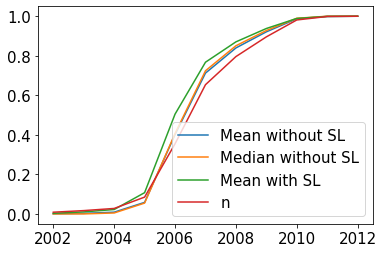

In [42]:
plt.plot(Years,[np.mean(S[t,:,:][mask_SL_t]/S[-1,:,:][mask_SL_t]) 
                for t in range(S.shape[0])],label='Mean without SL')
plt.plot(Years,[np.median(S[t,:,:][mask_SL_t]/S[-1,:,:][mask_SL_t]) 
                for t in range(S.shape[0])],label='Median without SL')
plt.plot(Years,S.mean(axis=(1,2))/S[-1,:,:].mean(),label='Mean with SL')
plt.plot(Years,n.mean(axis=1)/n[-1,:].mean(),label='n')
plt.legend()
# plt.plot(Years,n_.mean(axis=1)/np.max(n_.mean(axis=1)))
# plt.plot(Years,W.mean(axis=(1,2))/np.max(W.mean(axis=(1,2)))-n_.mean(axis=1)/np.max(n_.mean(axis=1)))

In [86]:
G0_s,p0_s = fit_model(travel_time_tensor,n_sus,'gravity',sigmoid=sigmoid,social=W)
G1_s,p1_s = fit_model(length_tensor,n_sus,'gravity',sigmoid=sigmoid,social=W)
G2_s,p2_s = fit_model(travel_time_tensor,n_sus,'gravity',
                      each_year=True,sigmoid=sigmoid,
                      bounds=([0,1,0],[np.inf,4,2]),social=W)
G3_s,p2_s = fit_model(length_tensor,n_sus,'gravity',
                      each_year=True,sigmoid=sigmoid,
                      bounds=([0,1,0],[np.inf,4,2]),social=W)

G_models_s = [G0_s,G1_s,G2_s,G3_s]
print([chi2(upper_triangle(W),upper_triangle(G)) for G in G_models_s])

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


[1367205.2546204957, 1781755.9092786657, 652529.2193136115, 368250.16841782595]


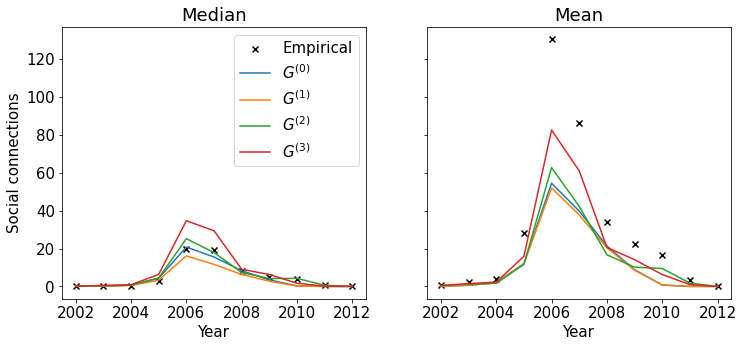

In [87]:
fig,axs=plt.subplots(figsize=(12,5),ncols=2,sharey=True)

axs[0].scatter(Years,[np.median(W[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
for v,g in enumerate(G_models_s):
    axs[0].plot(Years,[np.median(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[0].set_title("Median")
axs[0].legend()

axs[1].scatter(Years,[np.mean(W[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
for v,g in enumerate(G_models_s):
    axs[1].plot(Years,[np.mean(g[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(%s)}$'%v)
axs[1].set_title("Mean")

axs[0].set_ylabel("Social connections")
for i in range(2):
    axs[i].set_xlabel("Year")
#     axs[i].set_yscale('log')
# fig.savefig("../analysis/Figures/Gravity models adjusted.png",bbox_inches='tight')